In [195]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "data/mouse_drug_data.csv"
clinical_trial_data_to_load = "data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(mouse_drug_data_to_load)
clinical_df = pd.read_csv(clinical_trial_data_to_load)


# Combine the data into a single dataset
drug_df = pd.merge(mouse_df, clinical_df)


# Display the data table for preview
drug_df


,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2
...,...,...,...,...,...
1901,j235,Placebo,0,45.000000,0
1902,j235,Placebo,5,46.588820,0
1903,j235,Placebo,10,48.018788,1
1904,j235,Placebo,15,51.161138,1


## Tumor Response to Treatment

In [196]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
#Serches for the SEM of Tumor Volume for the grouped_df
sem_df = drug_df.groupby(['Drug','Timepoint']).sem()['Tumor Volume (mm3)']

#Makes our result a DataFrame
sem_df = pd.DataFrame(sem_df)

#Takes the same DataFrame but resets the index
new_df = sem_df.reset_index()

#Takes the SEM for each of the 4 treatments that we will use in our graph.
cap_sem = new_df.loc[new_df['Drug'] == 'Capomulin', :]
cap_sem = cap_sem['Tumor Volume (mm3)']

inf_sem = new_df.loc[new_df['Drug'] == 'Infubinol', :]
inf_sem = inf_sem['Tumor Volume (mm3)']

keta_sem = new_df.loc[new_df['Drug'] == 'Ketapril', :]
keta_sem = keta_sem['Tumor Volume (mm3)']

placebo_sem = new_df.loc[new_df['Drug'] == 'Placebo', :]
placebo_sem = placebo_sem['Tumor Volume (mm3)']



#Puts all of these SEM  into a list that we can use later when we're making the plot.
tumor_errors_list = [cap_sem, inf_sem, keta_sem, placebo_sem]





In [211]:
# Minor Data Munging to Re-Format the Data Frames


#Defines timepoints outside of the function
timepoints = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

#Since we will do this process multiple times (twice to be exact), we're making it a function.
#This function will take a parameter such as 'Tumor Volume (mm3)' or 'Metastastic Sites'
#It will find the data associated with the param and put that data for each drug and timepoint
#into a dataframe.

def datamunge(param):

    #Defines timepoints again (I did this first), I would delete 
    # this although I'm not sure I want to fix what isn't broken.
    timepoints = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
    
    #Creates a new DataFrame with all of the timepoints.
    new_df = pd.DataFrame()
    new_df['Timepoint'] = timepoints

    #Iterates through every drug
    for drug in drug_df['Drug'].unique(): 
        
        #Locates all the data for that drug and stores it in druggo_df.
        druggo_df = drug_df.loc[drug_df['Drug'] == drug, :]
        
        
        tumor_vals = []
        #Iterates through every timepoint
        for timepoint in timepoints:
            
            #Further filters our data to that which matches both the drug and timepoint.
            time_df = druggo_df.loc[druggo_df["Timepoint"] == timepoint, :]
            #Finds the mean of all of the data (we may have multiple mice going through the same drug)
            param_val = time_df[param].mean()
            
            #Appends it to our list outside of the loop.
            tumor_vals.append(param_val)
            
            #Once the tumor_vals list is complete, we will add the information to our new_df
        new_df[drug] = tumor_vals
    return new_df
        

#Stores our data into an appropriately names DataFrame
tumor_df = datamunge('Tumor Volume (mm3)')

        

# Preview that Reformatting worked
tumor_df

,Timepoint,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
0,0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
1,5,47.527452,47.248967,46.796098,47.389175,44.266086,47.062001,46.503051,46.851818,43.944859,47.125589
2,10,49.463844,49.101541,48.694210,49.582269,43.084291,49.403909,48.285125,48.689881,42.531957,49.423329
3,15,51.529409,51.067318,50.933018,52.399974,42.064317,51.296397,50.094055,50.779059,41.495061,51.359742
4,20,54.067395,53.346737,53.644087,54.920935,40.716325,53.197691,52.157049,53.170334,40.238325,54.364417
5,25,56.166123,55.504138,56.731968,57.678982,39.939528,55.715252,54.287674,55.432935,38.974300,57.482574
6,30,59.826738,58.196374,59.559509,60.994507,38.769339,58.299397,56.769517,57.713531,38.703137,59.809063
7,35,62.440699,60.350199,62.685087,63.371686,37.816839,60.742461,58.827548,60.089372,37.451996,62.420615
8,40,65.356386,63.045537,65.600754,66.068580,36.958001,63.162824,61.467895,62.916692,36.574081,65.052675
9,45,68.438310,66.258529,69.265506,70.662958,36.236114,65.755562,64.132421,65.960888,34.955595,68.084082


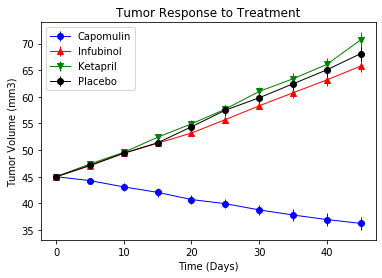

In [212]:
# Generate the Plot (with Error Bars)

#We will do this three times for the same drugs, so we're making a function.
#Remember tumor_errors_list from before? It was a list of all the SEMs for the four drugs that we're graphing.
#We'll pass lists like those through this function to get our error bars.

def make_plot(df, title, x_title, y_title, e_list):
    plt.errorbar(timepoints, df['Capomulin'], linewidth=1, marker="o", yerr=e_list[0]
                 , color="blue", label='Capomulin')
    plt.errorbar(timepoints, df['Infubinol'], linewidth=1, marker="^", color="red", yerr=e_list[1], label='Infubinol')
    plt.errorbar(timepoints, df['Ketapril'], linewidth=1, marker="v", color="green", yerr=e_list[2], label='Ketapril')
    plt.errorbar(timepoints, df['Placebo'], linewidth=1, marker="o", color="black", yerr=e_list[3], label='Placebo')

    
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.legend( loc="best")

#Plots our Tumor data with very small error bars.
make_plot(tumor_df, 'Tumor Response to Treatment', 'Time (Days)', 'Tumor Volume (mm3)', tumor_errors_list)
# Save the Figure
plt.savefig("../Images/TumorResponseToTreatment.png")

In [213]:
# Show the Figure
plt.show()

![Tumor Response to Treatment](../Images/treatment.png)

## Metastatic Response to Treatment

In [201]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 

# Convert to DataFrame

# Preview DataFrame


In [202]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 

#We're literally doing the same SEM process as before, but just with Metastatic Sites.
sem_df = drug_df.groupby(['Drug','Timepoint']).sem()['Metastatic Sites']

sem_df = pd.DataFrame(sem_df)
new_df = sem_df.reset_index()

cap_sem = new_df.loc[new_df['Drug'] == 'Capomulin', :]
cap_sem = cap_sem['Metastatic Sites']

inf_sem = new_df.loc[new_df['Drug'] == 'Infubinol', :]
inf_sem = inf_sem['Metastatic Sites']

keta_sem = new_df.loc[new_df['Drug'] == 'Ketapril', :]
keta_sem = keta_sem['Metastatic Sites']

placebo_sem = new_df.loc[new_df['Drug'] == 'Placebo', :]
placebo_sem = placebo_sem['Metastatic Sites']



#We're making this errors list so that we can pass it through our plot function.
meta_errors_list = [cap_sem, inf_sem, keta_sem, placebo_sem]


In [203]:
# Minor Data Munging to Re-Format the Data Frames
meta_df = datamunge('Metastatic Sites')

# Preview that Reformatting worked
meta_df

,Timepoint,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,0.240000,0.320000,0.260870,0.304348,0.160000,0.280000,0.380952,0.166667,0.120000,0.375000
2,10,0.478261,0.565217,0.523810,0.590909,0.320000,0.666667,0.600000,0.500000,0.250000,0.833333
3,15,0.782609,0.764706,0.857143,0.842105,0.375000,0.904762,0.789474,0.809524,0.333333,1.250000
4,20,0.952381,1.000000,1.150000,1.210526,0.652174,1.050000,1.111111,1.294118,0.347826,1.526316
5,25,1.157895,1.357143,1.500000,1.631579,0.818182,1.277778,1.500000,1.687500,0.652174,1.941176
6,30,1.388889,1.615385,2.066667,2.055556,1.090909,1.588235,1.937500,1.933333,0.782609,2.266667
7,35,1.562500,2.300000,2.266667,2.294118,1.181818,1.666667,2.071429,2.285714,0.952381,2.642857
8,40,1.583333,2.777778,2.466667,2.733333,1.380952,2.100000,2.357143,2.785714,1.100000,3.166667
9,45,1.727273,2.571429,2.538462,3.363636,1.476190,2.111111,2.692308,3.071429,1.250000,3.272727


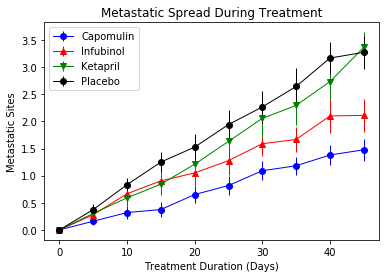

In [214]:
# Generate the Plot (with Error Bars) - Notice we're passing the meta_errors_list
make_plot(meta_df, 'Metastatic Spread During Treatment', 'Treatment Duration (Days)', 'Metastatic Sites', meta_errors_list)
# Save the Figure
plt.savefig("../Images/MetastaticSpreadDuringTreatment.png")


![Metastatic Spread During Treatment](../Images/spread.png)

## Survival Rates

In [205]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)

#Redefining timepoints so that the code is easier to read and you don't have to scroll up.
timepoints = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

#This is a similar process as before, yet we need to calculate what percentage of mice are still alive.
mice_df = pd.DataFrame()
mice_df['Timepoints'] = timepoints


for drug in drug_df['Drug'].unique():
    #Locate all the mice that use that particular drug.
    this_drug = drug_df.loc[drug_df["Drug"] == drug, :]
    #We use len to count the number of mice at the start.
    beginning_mice = len(this_drug.loc[this_drug["Timepoint"] == 0, :])
    
    percents = []
    #Since we've narrowed down the number of mice for the drug, we just need to see how many mice
    #survive each timepoint.
    for time in timepoints:
        #Calculates the number of mice still alive.
        mice_remaining = len(this_drug.loc[this_drug["Timepoint"] == time, :])
        #Calculates the percent remaining.
        percent_remaining = 100*mice_remaining/beginning_mice
        percents.append(percent_remaining)
    
    #Like our data munging function, we make a list of all the timepoint data for each drug and then put
    #that list into the dataframe.
    mice_df[drug] = percents


# Preview DataFrame
mice_df



,Timepoints,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
0,0,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,5,96.153846,96.153846,92.0,92.0,100.0,100.0,84.0,96.0,100.0,96.0
2,10,88.461538,88.461538,84.0,88.0,100.0,84.0,80.0,88.0,96.0,96.0
3,15,88.461538,65.384615,84.0,76.0,96.0,84.0,76.0,84.0,96.0,80.0
4,20,80.769231,65.384615,80.0,76.0,92.0,80.0,72.0,68.0,92.0,76.0
5,25,73.076923,53.846154,72.0,76.0,88.0,72.0,72.0,64.0,92.0,68.0
6,30,69.230769,50.000000,60.0,72.0,88.0,68.0,64.0,60.0,92.0,60.0
7,35,61.538462,38.461538,60.0,68.0,88.0,48.0,56.0,56.0,84.0,56.0
8,40,46.153846,34.615385,60.0,60.0,84.0,40.0,56.0,56.0,80.0,48.0
9,45,42.307692,26.923077,52.0,44.0,84.0,36.0,52.0,56.0,80.0,44.0


In [206]:
# Minor Data Munging to Re-Format the Data Frames

    
# Preview the Data Frame


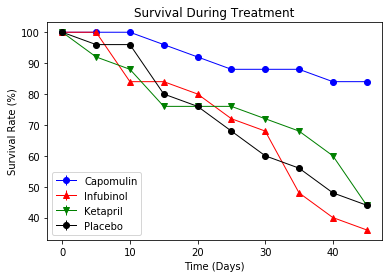

In [207]:
# Generate the Plot (Accounting for percentages)

#We plot the list of four 0s as the last parameter so that the SEM is 0 and the function doesn't plot an errorbar.
make_plot(mice_df, 'Survival During Treatment', 'Time (Days)', 'Survival Rate (%)', [0,0,0,0])

# Save the Figure
plt.savefig("../Images/SurvivalDuringTreatment.png")



![Metastatic Spread During Treatment](../Images/survival.png)

## Summary Bar Graph

In [208]:
# Calculate the percent changes for each drug

#I'm splitting the data into negative and positive lists so that it's easier to change the color
#of the bars later. I want positive tumor growth bars to be red and negative growth bars to be green.

#These lists will have the data we need to plot on the x and y axes.
plus_changes = []
plus_names = []
neg_changes = []
neg_names = []
for drug in drug_df['Drug'].unique():
    
    #Takes beginning and last values
    beg = tumor_df[drug][0]
    end = tumor_df[drug][9]
    percent_change = 100*(end - beg)/beg
    #Rounds our data
    percent_change = round(percent_change,2)
    
    #If it's positive, put the info into the positive lists.
    if int(percent_change) > 0:
        plus_changes.append(percent_change)
        plus_names.append(drug)
        
    #If it's negative, put the info into the negative lists.
    else:
        neg_changes.append(percent_change)
        neg_names.append(drug)
        



In [209]:

#I found this autolabel function on the internet and tried to tweak it so it would work and make data
#labels for each bar.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        
        #Only have this if statement because I want the label to be in a different place based
        #on whether the bar is going up (positive growth) or down(negative growth). It might make more
        #sense once you see the graph.
        if rects == rects1:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width(), height),
                        xytext=(-13, -2),  # -2 points vertical offset
                        textcoords='offset points',
                        ha='center', va='top')
        else:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width(), height),
                        xytext=(-12, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')






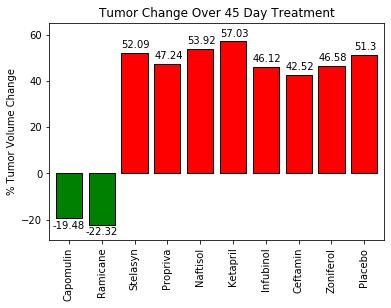

In [230]:
#Graphs our bar chart.
fig, ax = plt.subplots()
rects1 = plt.bar(neg_names, neg_changes, color="g", edgecolor='black', align="center")
rects2 = plt.bar(plus_names, plus_changes, color="r", edgecolor='black', align="center")


plt.title('Tumor Change Over 45 Day Treatment')
plt.ylabel('% Tumor Volume Change')
plt.xticks(rotation=90)

#Labels our data values.
autolabel(rects1)
autolabel(rects2)

#Slightly adjusts our limites
plt.xlim(-0.6, len(neg_names) + len(plus_names)-.4)
plt.ylim(-29, 65)

# Save the Figure
plt.savefig("../Images/TumorChangeBarChart.png")

# Show the Figure
plt.show()

![Metastatic Spread During Treatment](../Images/change.png)